# Проект для «Викишоп»

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Очистка-данных" data-toc-modified-id="Очистка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Очистка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

from sklearn.pipeline import make_pipeline, Pipeline
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

import re
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

import nltk
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


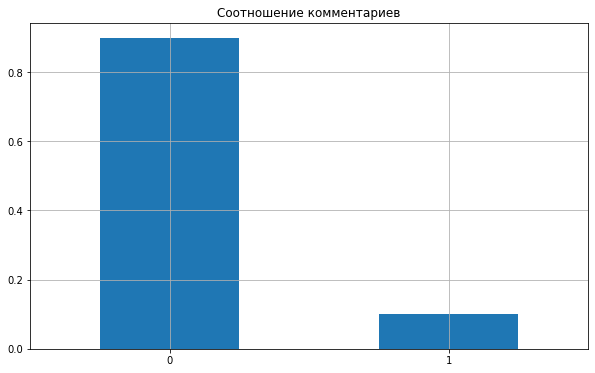

In [5]:
data['toxic'].value_counts(normalize=True).plot(kind='bar',
                                                grid=True, rot ='0',
                                                figsize=(10,6),
                                                title='Соотношение комментариев');

Присутствует дисбаланс классов 90%-10%,восстановим баланс перед обучением моделей.

### Очистка данных

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"that's", "that is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [7]:
data['text'] = data['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [8]:
data['text'] = data['text'].str.replace('_', ' ').str[:]

In [9]:
data

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27,0
1,1,d aww he matches this background colour i am seemingly stuck with thanks talk 21 51 january 11 2016 utc,0
2,2,hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0
3,3,more i cannot make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it listed in the relevant form eg wikipedia good article nominations transport,0
4,4,you sir are my hero any chance you remember what page that is on,0
...,...,...,...
159287,159446,and for the second time of asking when your view completely contradicts the coverage in reliable sources why should anyone care what you feel you cannot even give a consistent argument is the opening only supposed to mention significant aspects or the most significant ones,0
159288,159447,you should be ashamed of yourself that is a horrible thing you put on my talk page 128 61 19 93,0
159289,159448,spitzer umm theres no actual article for prostitution ring crunch captain,0
159290,159449,and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it,0


In [10]:
tokenizer = RegexpTokenizer(r'\w+')

In [11]:
data["tokens"] = data["text"].progress_apply(tokenizer.tokenize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
wn = nltk.WordNetLemmatizer()
stopwords.remove('not')
snowball = SnowballStemmer(language="english")
ps = nltk.stem.porter.PorterStemmer()

In [13]:
text_list = []
for token in tqdm(data['tokens']):
    text = [word for word in token if word not in stopwords]
    text = [snowball.stem(word) for word in text]
    text = ' '.join(text)
    text_list.append(text)
    del text
df = pd.concat([data,pd.Series(text_list)],axis=1)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [14]:
df.columns = ['0', 'text', 'toxic', 'tokens','lemm_text']

In [15]:
df = df.drop('0', axis=1)

In [16]:
df

,text,toxic,tokens,lemm_text
0,explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27,0,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, reverted, they, were, not, vandalisms, just, closure, on, some, gas, after, i, voted, at, new, york, dolls, fac, and, please, do, not, remove, the, template, from, the, talk, page, since, i, am, retired, now, 89, 205, 38, 27]",explan edit made usernam hardcor metallica fan revert not vandal closur gas vote new york doll fac pleas not remov templat talk page sinc retir 89 205 38 27
1,d aww he matches this background colour i am seemingly stuck with thanks talk 21 51 january 11 2016 utc,0,"[d, aww, he, matches, this, background, colour, i, am, seemingly, stuck, with, thanks, talk, 21, 51, january, 11, 2016, utc]",aww match background colour seem stuck thank talk 21 51 januari 11 2016 utc
2,hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,"[hey, man, i, am, really, not, trying, to, edit, war, it, just, that, this, guy, is, constantly, removing, relevant, information, and, talking, to, me, through, edits, instead, of, my, talk, page, he, seems, to, care, more, about, the, formatting, than, the, actual, info]",hey man realli not tri edit war guy constant remov relev inform talk edit instead talk page seem care format actual info
3,more i cannot make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it listed in the relevant form eg wikipedia good article nominations transport,0,"[more, i, cannot, make, any, real, suggestions, on, improvement, i, wondered, if, the, section, statistics, should, be, later, on, or, a, subsection, of, types, of, accidents, i, think, the, references, may, need, tidying, so, that, they, are, all, in, the, exact, same, format, ie, date, format, etc, i, can, do, that, later, on, if, no, one, else, does, first, if, you, have, any, preferences, for, formatting, style, on, references, or, want, to, do, it, yourself, please, let, me, know, there, appears, to, be, a, backlog, on, articles, for, review, so, i, guess, there, may, be, a, delay, until, a, reviewer, ...]",cannot make real suggest improv wonder section statist later subsect type accid think refer may need tidi exact format ie date format etc later one els first prefer format style refer want pleas let know appear backlog articl review guess may delay review turn list relev form eg wikipedia good articl nomin transport
4,you sir are my hero any chance you remember what page that is on,0,"[you, sir, are, my, hero, any, chance, you, remember, what, page, that, is, on]",sir hero chanc rememb page
...,...,...,...,...
159287,and for the second time of asking when your view completely contradicts the coverage in reliable sources why should anyone care what you feel you cannot even give a consistent argument is the opening only supposed to mention significant aspects or the most significant ones,0,"[and, for, the, second, time, of, asking, when, your, view, completely, contradicts, the, coverage, in, reliable, sources, why, should, anyone, care, what, you, feel, you, cannot, even, give, a, consistent, argument, is, the, opening, only, supposed, to, mentio

In [17]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

## Обучение

In [18]:
train, test = train_test_split(df[['lemm_text','toxic']],
                               test_size=0.1,
                               shuffle=True,
                               random_state=12345,
                               stratify=df['toxic'])

In [19]:
def train_test(df):
    X =  df['lemm_text']
    
    y = df['toxic']
    return X,y
X_train, y_train = train_test(train)
X_test, y_test = train_test(test)

In [20]:
%%time

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('logreg',LogisticRegression(penalty = 'l2',
                                 solver='liblinear',
                                 class_weight='balanced',
                                 random_state=12345))])

params = {'logreg__C': [6, 7, 8]}

grid = GridSearchCV(estimator=pipe,
                    param_grid=params,
                    cv=5, scoring='f1',
                    n_jobs=-1,
                    refit=False)

grid.fit(X_train, y_train)
best_paramms = grid.best_params_

print(best_paramms)
print(grid.best_score_)

{'logreg__C': 8}
0.7636551195038923
CPU times: user 4min 5s, sys: 2min 36s, total: 6min 42s
Wall time: 12min 46s


In [21]:
pipe_f = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('classifier', RandomForestClassifier(random_state=12345))])

params_f = {'classifier__max_depth': [9, 10, 11],
            'classifier__n_estimators': [70, 90, 110],
            'classifier__class_weight':['balanced']}

grid_f = GridSearchCV(estimator=pipe_f,
                      param_grid=params_f,
                      cv=5, scoring='f1',
                      n_jobs=-1,
                      refit=False)

grid_f.fit(X_train, y_train)
best_paramms_f = grid_f.best_params_

print(best_paramms_f)
print(grid_f.best_score_)

{'classifier__class_weight': 'balanced', 'classifier__max_depth': 11, 'classifier__n_estimators': 110}
0.3576958187936091


In [22]:
pipe2 = Pipeline([('TfIdf',TfidfVectorizer(stop_words=stopwords)),
                  ('logreg',LogisticRegression(C=8, penalty = 'l2',
                                               solver='liblinear',
                                               class_weight='balanced',
                                               random_state=12345))])

pipe2.fit(X_train, y_train)
y_pred = pipe2.predict(X_test)
print("Значение метрики F1",f1_score(y_test, y_pred))

Значение метрики F1 0.7695345557122709


## Выводы

Датасэт из 159292 комментариев, с дисбалансом, 10% токсичные,  90% как не токсичные. С помощью регулярных выражений были убраны символы, кавычки, ссылки и сокращения. Проведена токенизация и лемматизация. Лучшее значение метрики F1 достигнуто на модели LogisticRegression, значение на тесте составило 0.7699